#### the goal here is to implement some simple models for correlated noise (because of sky residuals and flux calibration)

following the SimulationsExample.ipynb notebook in specsim to get things going. currently running things for 500 fibers.

- [base simulation](#base-sim)
- [modification 1](#mod1): sky spectrum zeroed for some wavelengths
- [modification 2](#mod1): sky spectrum has a wavelength-dependent slope

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

import specsim.simulator

<a id="base-sim"></a>

In [3]:
# set up the simulator with default config
%time desi = specsim.simulator.Simulator('desi', num_fibers=500, verbose=False)

CPU times: user 8.55 s, sys: 3.39 s, total: 11.9 s
Wall time: 12.2 s


In [4]:
def generate_fiber_positions(sim=desi, seed=123):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=sim.num_fibers)) * sim.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=sim.num_fibers)
    return (np.vstack([np.cos(phi), np.sin(phi)]) * focal_r).T

def plot_focal_xy(sim=desi):
    plt.scatter(sim.focal_x.to(u.mm).value, sim.focal_y.to(u.mm).value, s=10, lw=0)
    r = 1.05 * sim.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')

CPU times: user 826 µs, sys: 632 µs, total: 1.46 ms
Wall time: 1.1 ms

## simulating ... 
CPU times: user 6.85 s, sys: 3.97 s, total: 10.8 s
Wall time: 12 s
CPU times: user 1.01 s, sys: 56.7 ms, total: 1.06 s
Wall time: 850 ms


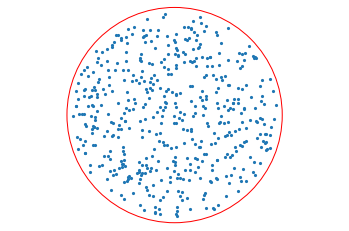

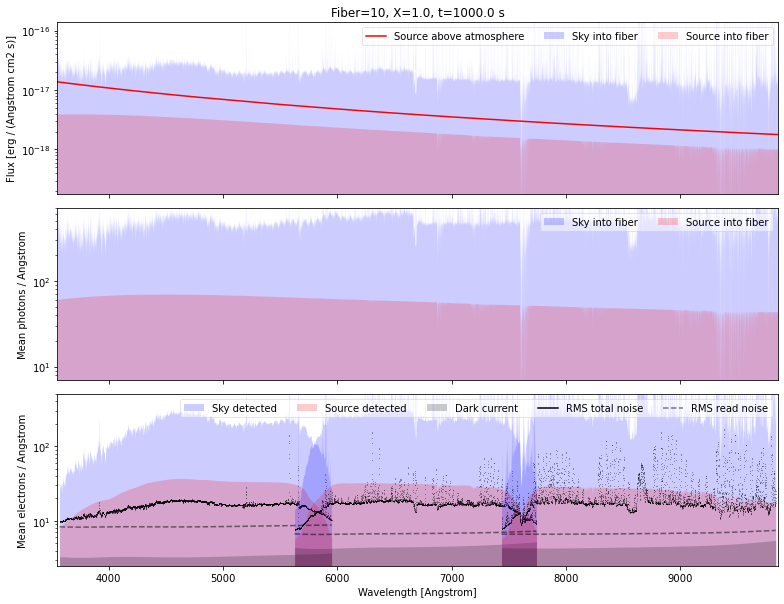

In [5]:
# generate random fiber positions
%time xy = generate_fiber_positions()

print('\n## simulating ... ')
%time desi.simulate(focal_positions=xy)

# plot fiber positions
plot_focal_xy()

%time desi.plot(fiber=10)

## lets read in the sky spectrum currently being used

In [6]:
import os
desimodel_path = '/Users/humnaawan/repos/desi/desimodel/0.10.3/data/'
desimodel_spectra_path = '%s/spectra' % desimodel_path
[f for f in os.listdir(desimodel_spectra_path) if f.__contains__('sky')]

['spec-sky-bright.dat',
 'spec-sky.dat',
 'spec-sky-grey.dat',
 'spec-sky-modified.dat']

In [7]:
from pyutils import settings

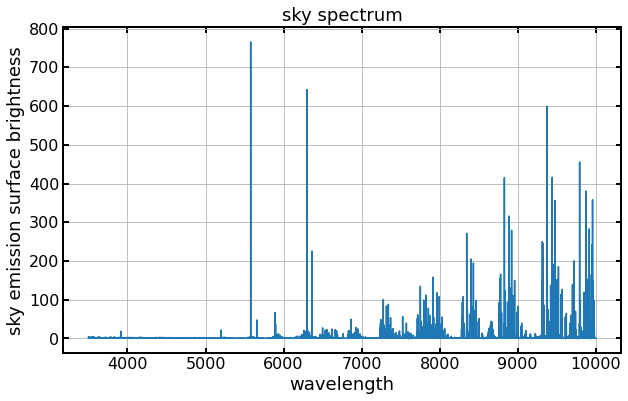

In [8]:
data_sky = np.genfromtxt('%s/spec-sky.dat' % desimodel_spectra_path)

plt.clf()
plt.plot(data_sky[:, 0], data_sky[:, 1])
plt.xlabel('wavelength')
plt.ylabel('sky emission surface brightness')
plt.title('sky spectrum')
plt.show()

<a id="mod1"></a>

### modification1: zero out some wavelengths

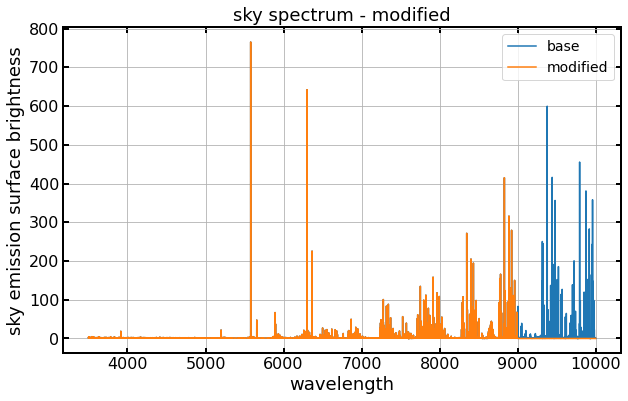

In [9]:
# just to test things, lets modify the spectrum "drastically" and see that changes things
data_sky_modified = np.zeros_like(data_sky)

# get the wavelengths' data over
data_sky_modified[:, 0] = data_sky[:, 0]
# now zero out the spectrum for some large wavelengths
ind = np.where( data_sky[:, 0] < 9000)[0]
data_sky_modified[ind, 1] = data_sky[ind, 1]

# plot
plt.clf()
plt.plot(data_sky[:, 0], data_sky[:, 1], label='base')
plt.plot(data_sky_modified[:, 0], data_sky_modified[:, 1], label='modified')

plt.xlabel('wavelength')
plt.ylabel('sky emission surface brightness')
plt.title('sky spectrum - modified')

plt.legend(loc='best')
#plt.xlim(8000, 9000)
plt.show()

In [10]:
# lets save it
fname = '%s/mydata/spec-sky-modified_zero-lambda>=9000.dat' % desimodel_path
np.savetxt(fname, data_sky_modified)

In [11]:
# lets re-run set up the simulator with the modified sky
import yaml

config_path = 'configs/desi_modified-sky1.yaml'
with open(config_path, 'r') as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
config = specsim.config.Configuration(config)
desi1 = specsim.simulator.Simulator(config, num_fibers=500, verbose=False)


## simulating ... 
CPU times: user 9.72 s, sys: 9.76 s, total: 19.5 s
Wall time: 30.3 s
CPU times: user 1.12 s, sys: 1.14 s, total: 2.26 s
Wall time: 2.52 s


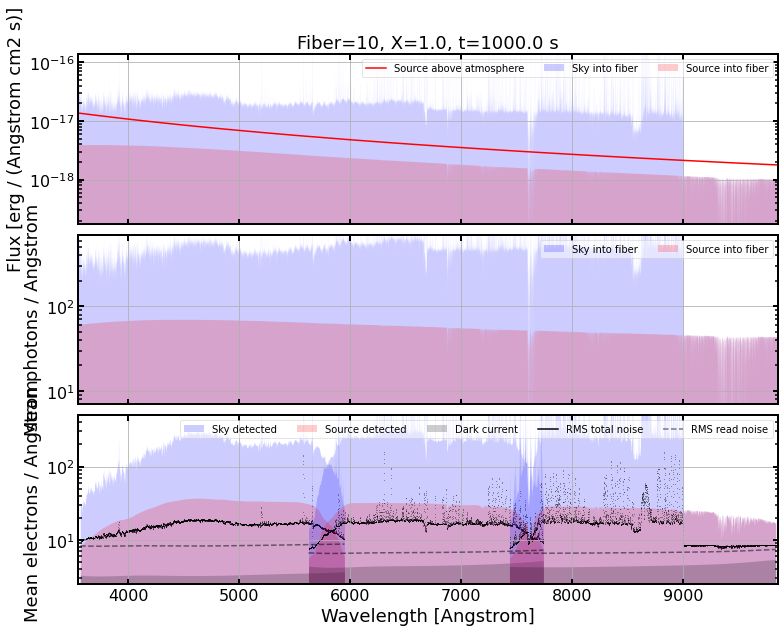

In [12]:
print('\n## simulating ... ')
%time desi1.simulate(focal_positions=xy)

# plot fiber positions
#plot_focal_xy()

%time desi1.plot(fiber=10)

okay things appear to be working - we dont detected sky at the large-wavelength end.

#### lets plot out some of the outputs

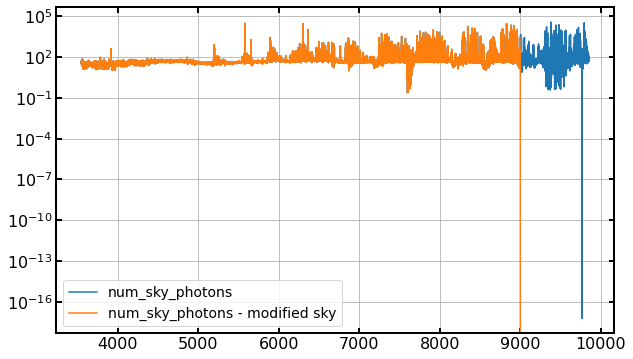

In [13]:
fiber = 10
key = 'num_sky_photons'

plt.plot(desi.simulated['wavelength'], desi.simulated[key][:, fiber],
         label=key)
plt.plot(desi1.simulated['wavelength'], desi1.simulated[key][:, fiber],
         label='%s - modified sky' % key)

plt.gca().set_yscale('log')
plt.legend(loc='best')
plt.show()

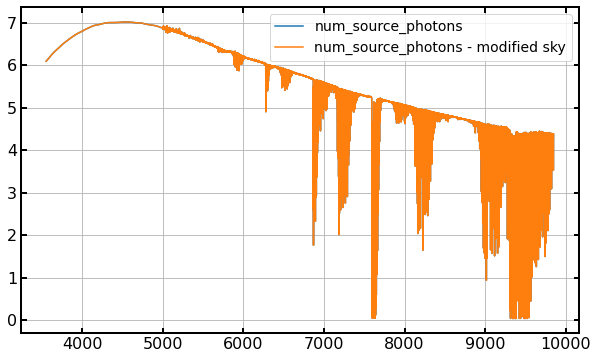

In [14]:
fiber = 10
key = 'num_source_photons'

plt.clf()
plt.plot(desi.simulated['wavelength'], desi.simulated[key][:, fiber],
         label=key)

plt.plot(desi1.simulated['wavelength'], desi1.simulated[key][:, fiber],
         label='%s - modified sky' % key)

#plt.gca().set_yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

hm .. source photons dont change. is that supposed to be okay? yes, im providing the modified sky spectrum so its being corrected for.

<a id="mod2"></a>

### modification2: add a wavelength-dependent component to the sky spectrum

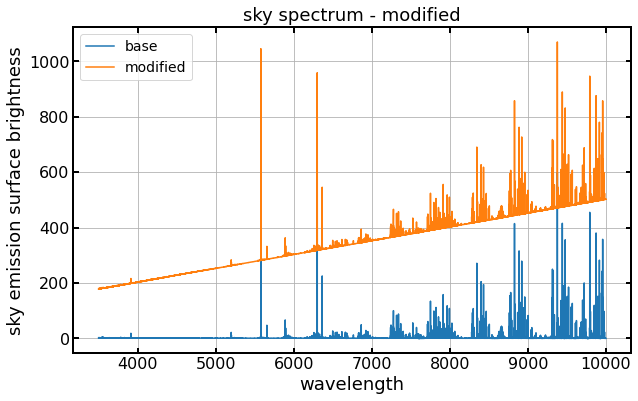

In [15]:
# just to test things, lets modify the spectrum "drastically" and see that changes things
data_sky_modified = np.zeros_like(data_sky)

# get the wavelengths' data over
data_sky_modified[:, 0] = data_sky[:, 0]
# now add a wavelength-dependent amplitude to the spectrum: original spectrum + fake
data_sky_modified[:, 1] = data_sky[:, 1] + (data_sky[:, 0] * .05 + 2)

# plot
plt.clf()
plt.plot(data_sky[:, 0], data_sky[:, 1], label='base')
plt.plot(data_sky_modified[:, 0], data_sky_modified[:, 1], label='modified')

plt.xlabel('wavelength')
plt.ylabel('sky emission surface brightness')
plt.title('sky spectrum - modified')

plt.legend(loc='best')
#plt.xlim(8000, 9000)
plt.show()

In [16]:
# lets save it
fname = '%s/mydata/spec-sky-modified_lambda-dep.dat' % desimodel_path
np.savetxt(fname, data_sky_modified)

In [17]:
# lets re-run set up the simulator
import yaml

config_path = 'configs/desi_modified-sky2.yaml'
with open(config_path, 'r') as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
config = specsim.config.Configuration(config)
desi2 = specsim.simulator.Simulator(config, num_fibers=500, verbose=False)


## simulating ... 
CPU times: user 8.51 s, sys: 7.6 s, total: 16.1 s
Wall time: 20 s
CPU times: user 1.08 s, sys: 540 ms, total: 1.62 s
Wall time: 1.29 s


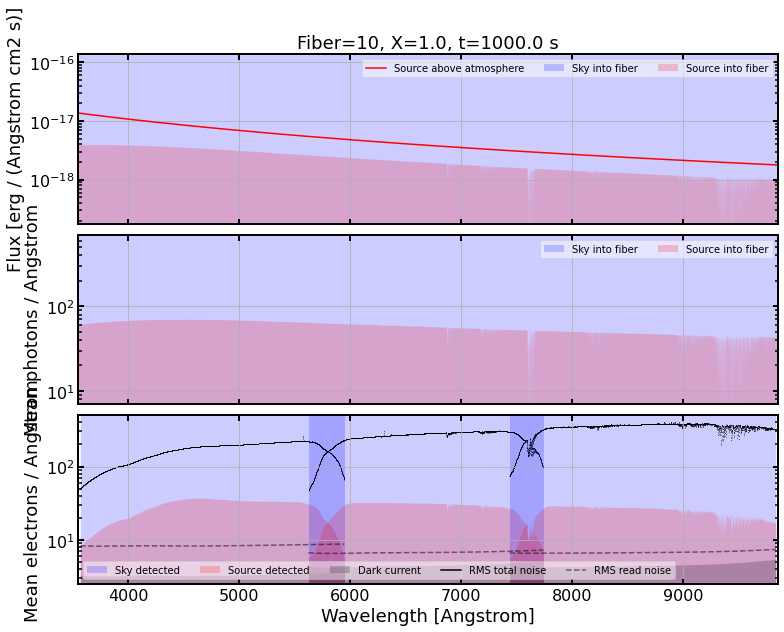

In [18]:
print('\n## simulating ... ')
%time desi2.simulate(focal_positions=xy)

# plot fiber positions
#plot_focal_xy()

%time desi2.plot(fiber=10)

okay things appear to be working - the sky detected level is higher and the readout noise is larger. source detected part doesnt change since the modified sky spectrum is being accounted for.

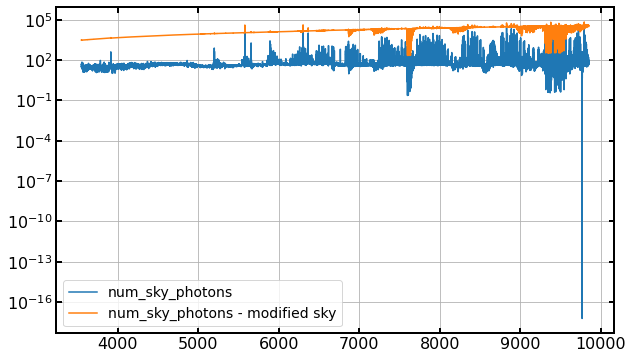

In [19]:
fiber = 10
key = 'num_sky_photons'

plt.plot(desi.simulated['wavelength'], desi.simulated[key][:, fiber],
         label=key)
plt.plot(desi2.simulated['wavelength'], desi2.simulated[key][:, fiber],
         label='%s - modified sky' % key)

plt.gca().set_yscale('log')
plt.legend(loc='best')
plt.show()

good - the modified sky spectrum is coming through.

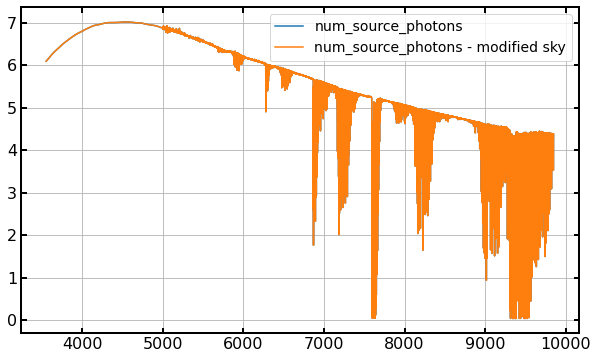

In [20]:
fiber = 10
key = 'num_source_photons'

plt.clf()
plt.plot(desi.simulated['wavelength'], desi.simulated[key][:, fiber],
         label=key)
plt.plot(desi2.simulated['wavelength'], desi2.simulated[key][:, fiber],
         label='%s - modified sky' % key)

#plt.gca().set_yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

we see the same thing as above: the modified sky spectrum is being accounted for.

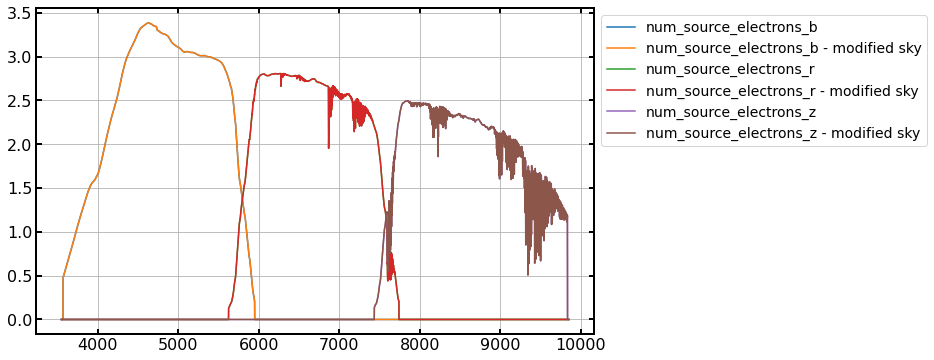

In [21]:
fiber = 10

for key in ['num_source_electrons_b', 'num_source_electrons_r', 'num_source_electrons_z']:
    plt.plot(desi.simulated['wavelength'], desi.simulated[key][:, fiber],
             label=key)
    plt.plot(desi2.simulated['wavelength'], desi2.simulated[key][:, fiber],
             label='%s - modified sky' % key)

#plt.gca().set_yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

unclear what these band-passes like outputs are.

In [64]:
desi.simulated.keys()

['wavelength',
 'source_flux',
 'fiberloss',
 'source_fiber_flux',
 'sky_fiber_flux',
 'num_source_photons',
 'num_sky_photons',
 'num_source_electrons_b',
 'num_sky_electrons_b',
 'num_dark_electrons_b',
 'read_noise_electrons_b',
 'num_source_electrons_r',
 'num_sky_electrons_r',
 'num_dark_electrons_r',
 'read_noise_electrons_r',
 'num_source_electrons_z',
 'num_sky_electrons_z',
 'num_dark_electrons_z',
 'read_noise_electrons_z']

In [82]:
?specsim.simulator.Simulator

In [56]:
?specsim.config.Configuration

In [87]:
?desi2.plot